In [2]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import argparse
import os
import sys
sys.path.append('..')

import wandb
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from src.models import SimpleModel
from src.training import warmup, dispatch_lr_scheduler, get_lr, dispatch_optimizer
from src.metrics import compute_accuracy, compute_confusion_matrix, compute_loss, plot_confusion_matrix
from src.dataset import get_train_dataset, get_test_dataset, get_test_dataloader, get_train_dataloader
from src.utils import parse_args

## Dataset

In [3]:
test_dataset = get_test_dataset('../data/dnn2020-1/test/')

In [4]:
def plot_celebs(dataset, celeb_class=0):
    i = celeb_class
    fs = [Image.open(img_path).resize((100, 100)) for img_path, _ in dataset.samples[i*99:(i+1)*99]]
    x,y = fs[0].size
    ncol, nrow = 9, 11
    cvs = Image.new('RGB',(x*ncol,y*nrow))
    for i in range(len(fs)):
        px, py = x*(i%ncol), y*int(i/ncol)
        cvs.paste(fs[i],(px,py))
    return cvs

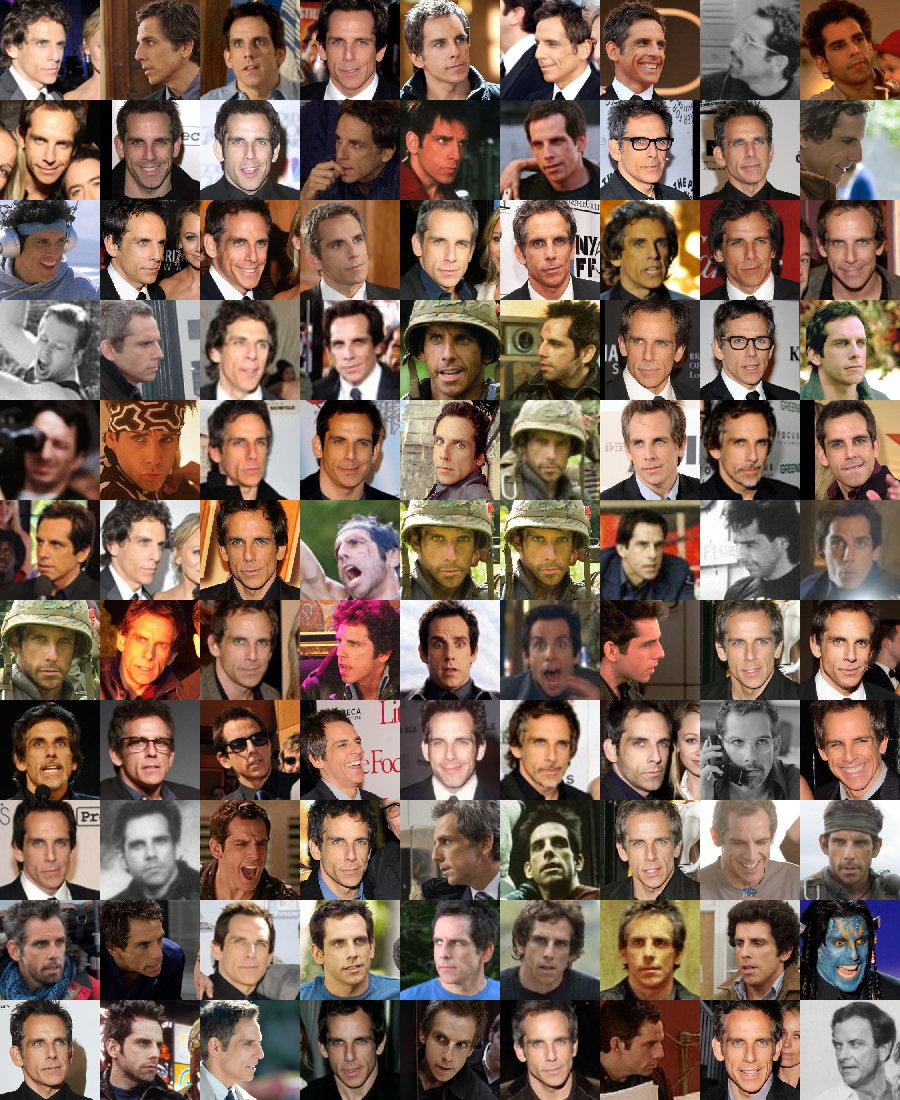

In [5]:
plot_celebs(test_dataset, 4)

* Many classes have some images not belonging to their's distribution. For instance Class 0 has at least 2 such images
* Class 7, with Jamie Foxx, contains Ray Charles 
* Neil Patrick Harrison has some kid in his distribution
* Class 1 is very diverse. Gray and RGB images. Sunglasses. Various hair color. Various age stage

* Some classes have repetitions (class 4 for example)

* Female classes havevarious color hair which may be challenging for CNN

* Some images are grayscale. Most of them are RGB

* Some images contain multiple faces (class 19)

* Some female classes contain guys ... (class 20)


Looking at this with my caveman eyes I would guess that human expert could easily approach ~95%
I think moderately complex CNN could get 80%. And complex CNN like ResNet could go as far as human expert
100% is out of reach due to error images

## Network Architecture

In [6]:
cmd = '--data-dir ../data/dnn2020-1 -lr 3e-3 --epochs 15 --warmup 25 --augmentation --momentum 0.9 --weight-decay 0.001 --use-bn'
args = parse_args(cmd.split(' '))

In [7]:
use_cuda = not args.use_cpu and torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

In [11]:
model = SimpleModel(custom_batchnorm=True, use_bn=args.use_bn).to(device)
model

SimpleModel(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (5): BatchNorm()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
    (9): BatchNorm()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (13): BatchNorm()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): ReLU(inplace=True)
  )
  (linear): Linear(in_features=12800, out_features=28, bias=True)
  (softmax): Softmax(dim=1)
)

Network contains 4 conv layers and 1 FC layer. 

Because of of the hard limit of at most 4 conv layers I decided to use kernels 7x7 in order to increase the receptive filed of a network. With 7x7 and 4 conv layers te effective receptive filed is 25x25 which is (10%)x(10%) of an image. 

Alse I have used BatchNorm layers between conv layer and nonlinearity. 

## Experiments

### Training best model

In [ ]:
train_dataloader = get_train_dataloader(os.path.join(args.data_dir, 'train/'), args.train_batch_size, args.augmentation)
test_dataloader = get_test_dataloader(os.path.join(args.data_dir, 'test/'), args.test_batch_size)

wandb.init(project="classifying-celebrities", config=args)
wandb.watch(model, log='all')
config = wandb.config

loss_function = CrossEntropyLoss(reduction='mean')
optimizer = dispatch_optimizer(model, args)
lr_scheduler = dispatch_lr_scheduler(optimizer, args)

iteration = 0
training_accuracy = compute_accuracy(model, train_dataloader, device)
test_accuracy = compute_accuracy(model, test_dataloader, device)
print(f'Before training\nTrainign acc: {training_accuracy}.  Test acc: {test_accuracy}\n')
wandb.log({'training accuracy': training_accuracy}, step=iteration)
wandb.log({'test_accuracy': test_accuracy}, step=iteration)
    
for epoch in range(args.epochs):
    for x, y in train_dataloader:
        if iteration < args.warmup:
            warmup(iteration, optimizer, args.learning_rate, args.warmup)
        x, y = x.to(device), y.to(device)
        y_raw_prediction, _ = model(x)
        loss = loss_function(y_raw_prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({'training loss': loss}, step=iteration)
        wandb.log({'learning rate': get_lr(optimizer)}, step=iteration)

        if iteration % 10 == 0:
            test_loss = compute_loss(model, test_dataloader, loss_function, device)
            wandb.log({'test loss': loss}, step=iteration)
        wandb.log({'iteration': iteration}, step=iteration)
        iteration += 1

    lr_scheduler.step()
    training_accuracy = compute_accuracy(model, train_dataloader, device)
    test_accuracy = compute_accuracy(model, test_dataloader, device)
    print(f'Epoch {epoch}\nTrainign acc: {training_accuracy}.  Test acc: {test_accuracy}\n')
    wandb.log({'training accuracy': training_accuracy}, step=iteration)
    wandb.log({'test_accuracy': test_accuracy}, step=iteration)

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Before training
Trainign acc: 0.028214285714285713.  Test acc: 0.027777777777777776

Epoch 0
Trainign acc: 0.38169642857142855.  Test acc: 0.4051226551226551

Epoch 1
Trainign acc: 0.6001785714285715.  Test acc: 0.6002886002886003

Epoch 2
Trainign acc: 0.6741964285714286.  Test acc: 0.674963924963925

Epoch 3
Trainign acc: 0.7392857142857143.  Test acc: 0.6976911976911977

Epoch 4
Trainign acc: 0.7534821428571429.  Test acc: 0.7366522366522367

Epoch 5
Trainign acc: 0.8188392857142858.  Test acc: 0.7766955266955267

Epoch 6
Trainign acc: 0.8526785714285714.  Test acc: 0.7961760461760462

Epoch 7
Trainign acc: 0.8702678571428571.  Test acc: 0.8015873015873016

Epoch 8
Trainign acc: 0.8798214285714285.  Test acc: 0.823953823953824

Epoch 9
Trainign acc: 0.9032142857142857.  Test acc: 0.8326118326118326

Epoch 10
Trainign acc: 0.9077678571428571.  Test acc: 0.8253968253968254



### Accuracy and loss plots

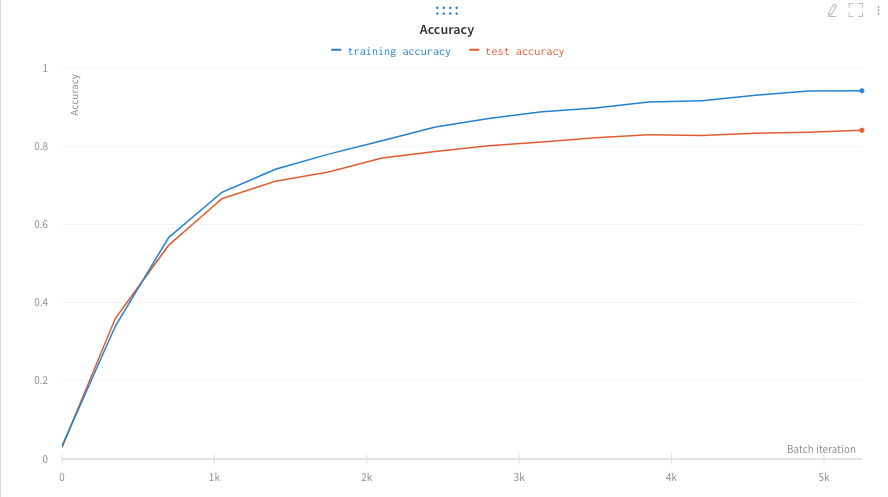

In [113]:
Image.open('accuracy_plots.png')

* 15 epochs
* SGD with momentum 0.9
* signs of overfitting (train acc > test acc)
* Both accuracies start at 100% * 1/num_class which is good sanity check

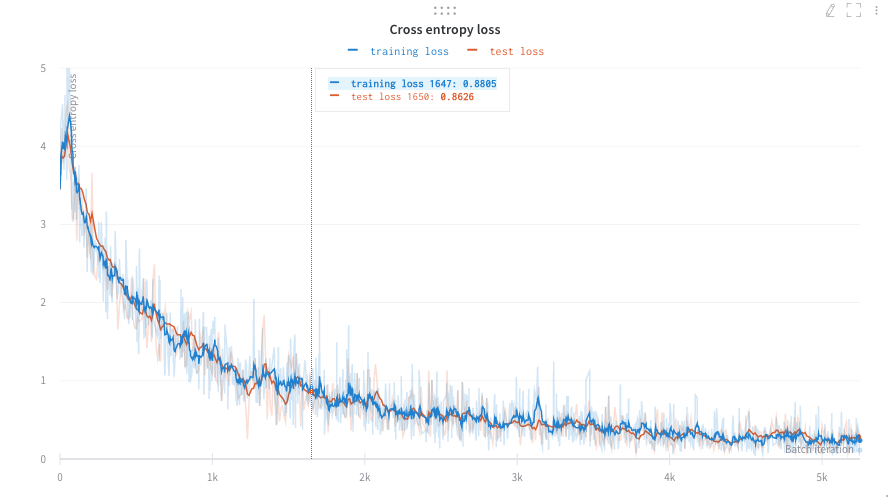

In [114]:
Image.open('loss_plots.png')

* No signs of overfitting in loss plot
* Both losses start at ~3.3 (-ln(1/28)) which is good sanity check

### Batch size vs accuracy

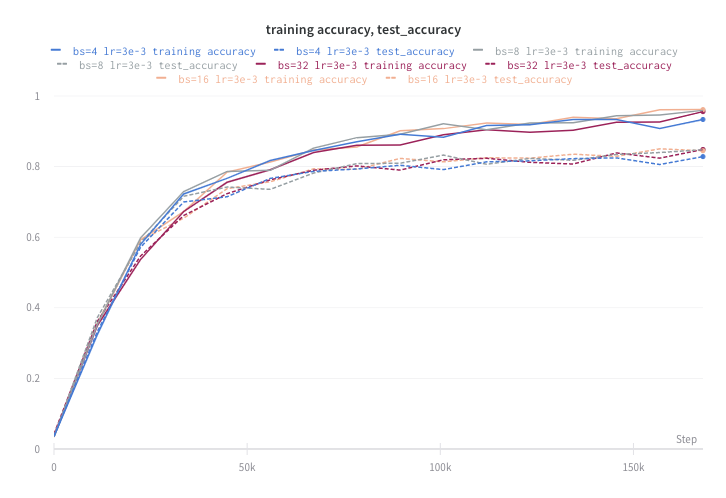

In [115]:
Image.open('batch_vs_acc.png')

* tested $ BS \in$ {4, 8, 16, 32}
* every BS converged to ~84-85% test accuracy
* all of them had the same training characteristics
* the less BS was the more stochastic loss characteristics was

### Batch normalization vs accuracy

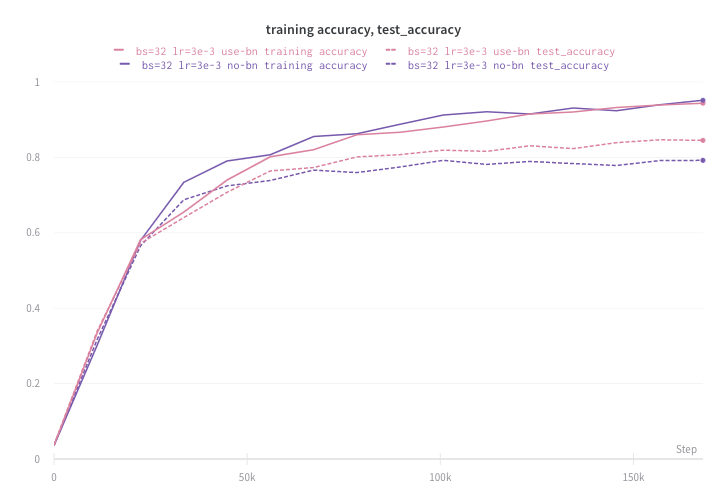

In [3]:
Image.open('bn_vs_nobn.png')

* Model with BN overfits less and later
* Model with Bn gets ~84% accuracy where model without BN gets as far as 79% accuracy
* Model with custom BN needs ~39% more time to train compared with model without BN

### Optimizers vs accuracy

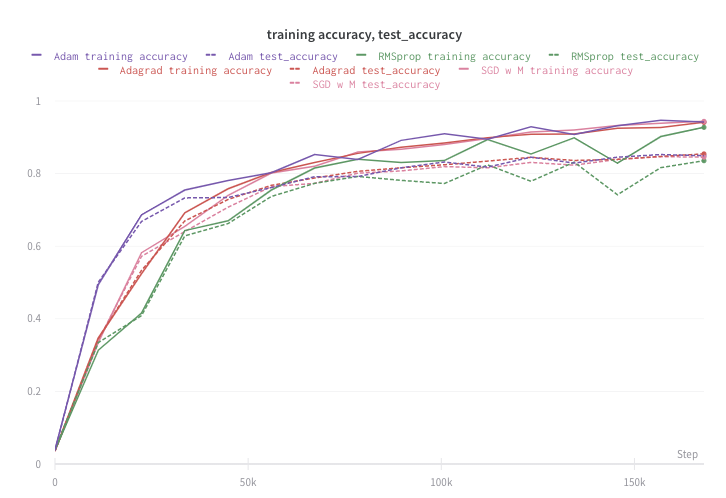

In [4]:
Image.open('optims_acc.png')

* All optimizers reach roughly the same accuracy
* Adam seems to reach "decent accuracy" faster than others but it reaches final "best" accuracy with the same speed
* RMSprop seems to be more stochastic
* All optimizers have been tried with few hyperparameters but it was no exhaustive study
* Accoriding to many papers SGDwM is good enough and there is no need to use "fancy" optimizers
* Practically I would go with SGDwM or Adam since it's popular among many

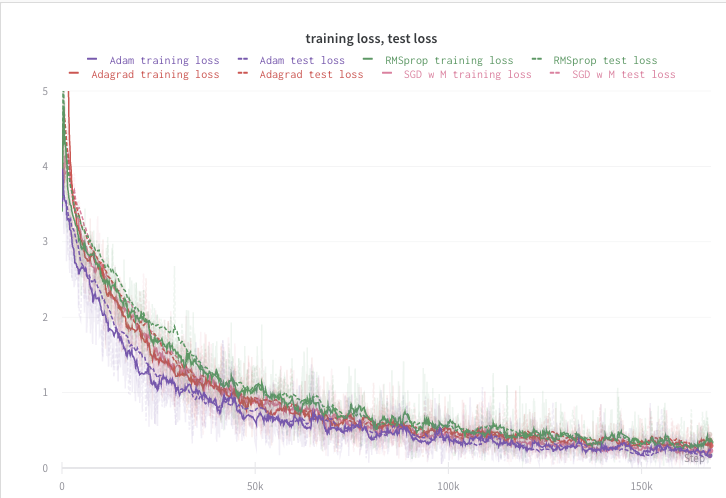

In [5]:
Image.open('optims_loss.png')

### Confusion matrix

In [100]:
conf_matrix = compute_confusion_matrix(model, test_dataloader, device)

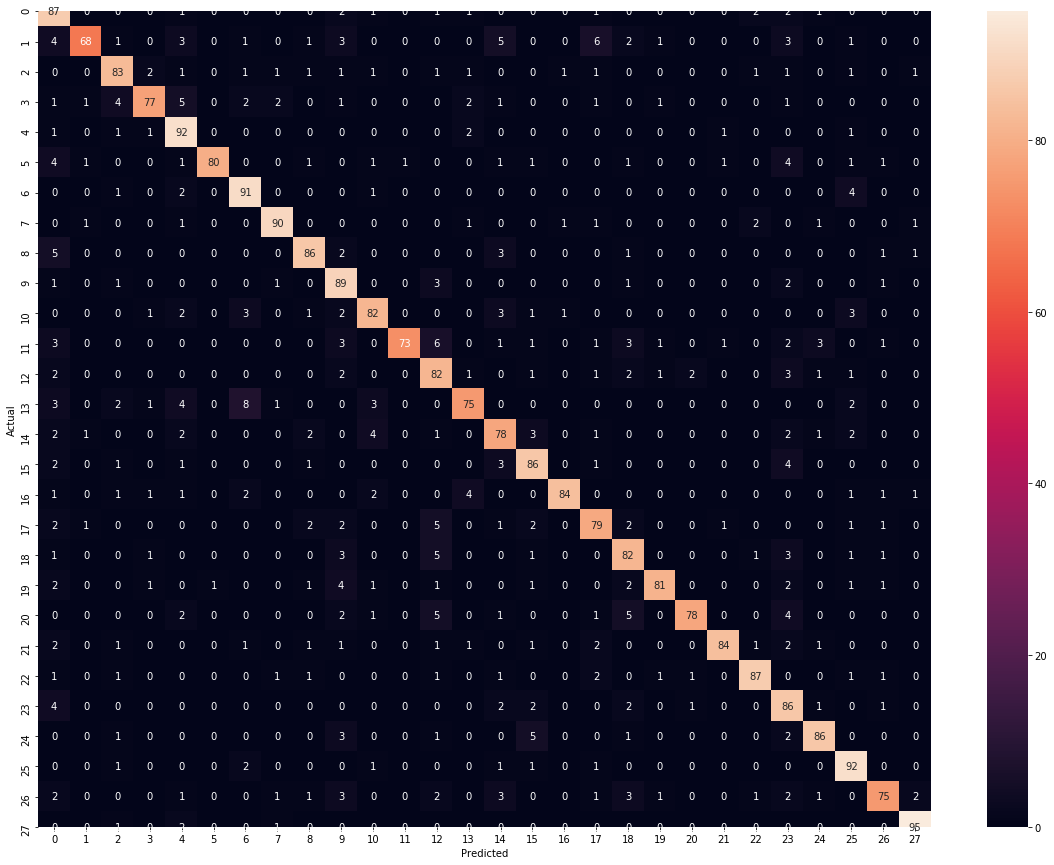

In [101]:
plot_confusion_matrix(conf_matrix)

* Ideally diagonal would have 99 <=> 100% accuracy
* Many images from {1..27} classes have quite a few images predicted as class 0
* Worst performance is on class 1 - Angelina Jolie. I've already mention that this class is very diverse
* Best performance is on class 4. Lots of repetitions there